# MAAP helps compare NASA L-band and ESA P-band radar data versus field biomass to generate model-based biomass maps


_MAAP NASA-ESA Face-2-Face meeting, 16 April 2019, Annapolis._

## Overview of the excercise

NASA and ESA radar data are searched in CMR and downloaded locally for further processing. NASA radar data are L-band JPL/UAVSAR acquisitions previously processed to the L2 Geocoded Covariance matrix product using the prototypical NISAR processor. ESA radar data are P-band DLR/F-SAR acquisitons processed to the L1 Single-Look-Complex product. Field data are  uploaded locally by the user and used in this notebook to calibrate backscatter radar models. All data have been acquired in the context of the 2016 AfriSAR campaign in Gabon. The diagram below shows the workflow, starting from downloading and reading of the data, display, co-location, model fit and multi-frequency data-model intercomparison. 

**Note**: _The purpose of this notebook is to illustrate the capabilities of the MAAP (Pilot D2 version) and PLAnT (beta 0.37 version). The workflow is not optimized for biomass calibration and estimation. UAVSAR data have been generated with the prototype NISAR processor (ISCE). Use of lidar data has been deliberately omitted in the notebook for brevity. Other libraries (sich as the R BIOMASS package) may be included in future versions._ 

![caption](D2_diagram.png)

## 1. Prepare the Python environment

Load the PLAnT package and set the global options that will be used in the notebook. PLAnT is freely available at `gitlab.com/plant/plant/`. The MAAP package is available in a GitHub repository (currently private).

In [25]:
%matplotlib inline

import plant
import numpy as np
import glob
import multiprocessing
from os import path

import maap
from maap.maap import MAAP
maap = MAAP()

options = {}
options['mute']  = True
options['force'] = True
options['output_skip_if_existent'] = False

display_options  = {}
display_options['mute'] = True


## 2. Search for and read NASA and ESA AfriSAR radar data over Lope National Park (Gabon)

Set the input radar data: 
    1. Geocoded Covariance Matrix acquired by the NASA UAVSAR (L-band) instrument
    2. HV SLC of the ESA/DLR F-SAR (P-band) instrument. P-band data are geocoded and corrected for the incidence angle dependency using ESA's approach (provided by C. Albinet)  

In [26]:
#Order of polarizations for SLC is: HH, HV, VH, VV
POLs = { "HH": 1, "HV": 2, "VH": 3, "VV": 4 }

# NASA L-band radar data (input)
input_dir = './input/afrisar_maap/'

# NASA L-band radar data (input)
lb_name = 'AfriSAR_UAVSAR_Geocoded_Covariance'
lband_granules = \
    maap.searchGranule(short_name=lb_name, track_number='002', polarization='HH HH') + \
    maap.searchGranule(short_name=lb_name, track_number='002', polarization='HV HV') + \
    maap.searchGranule(short_name=lb_name, track_number='002', polarization='VV VV') + \
    maap.searchGranule(short_name=lb_name, track_number='002', polarization='HH VV')

# Download CMR granules
lband_files = [f.getLocalPath(input_dir + 'nasa') for f in lband_granules]
#lband_files = glob.glob(input_dir + 'nasa/*')

[print("Found " + path.basename(p)) for p in lband_files]

def cov(ch1, ch2):
    return next(lb for lb in lband_files if lb.endswith(f"{POLs[ch1]}-{POLs[ch2]}.bin"))
    
cov_LHH   = cov('HH','HH')
cov_LHV   = cov('HV','HV')
cov_LVV   = cov('VV','VV') 
cov_LHHVV = cov('HH','VV') 

# ISCE-generated topofiles after multi-lookung 9x41
topo_dir = path.join(input_dir, 'topo_a41_r9')
inc_file_sr = path.join(topo_dir, 'localInc.rdr')

Found uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_1-1.hdr
Found uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_1-1.bin
Found uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_2-2.hdr
Found uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_2-2.bin
Found uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_4-4.hdr
Found uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_4-4.bin
Found uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_1-4.hdr
Found uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_1-4.bin


Set output file and folder paths as well as multi-look parameters

In [27]:
# NASA L-band radar data (output)
inc_file = path.join(input_dir, 'topo_a41_r9_geo/localInc.rdr')
sin_inc_file = path.join(input_dir, 'topo_a41_r9_geo/sinLocalInc.rdr')
output_dir = path.join(input_dir, 'output-D2-demo')
output_uavsar = path.join(output_dir, 'output_uavsar')
output_field = path.join(output_dir, 'output_field')
output_ext = 'tif'
file_LHH = path.join(output_uavsar, f'LHH.{output_ext}')
file_LHV = path.join(output_uavsar, f'LHV.{output_ext}')
file_LVV = path.join(output_uavsar, f'LVV.{output_ext}')
file_LHHVV = path.join(output_uavsar, f'LHHVV.{output_ext}')

# cropping parameters/multi-look
nlooks_az = 1
nlooks_rg = 1

Search for ESA AfriSAR data, correct for incidence angle variation and geocode using ESA's algorithm implemented in PLAnT 

In [29]:
pool = multiprocessing.Pool(4)

# Radar data
radarGranules = \
    maap.searchGranule(granule_ur='afrisar_dlr_T2-0_rg.tiff') + \
    maap.searchGranule(granule_ur='afrisar_dlr_T2-0_az.tiff') + \
    maap.searchGranule(granule_ur='afrisar_dlr_T2-0_SLC_HV.tiff') + \
    maap.searchGranule(granule_ur='afrisar_dlr_T2-0_inc.tiff') 

async_results = [ pool.apply_async(i.getLocalPath(input_dir + 'esa'), (i,)) for i in radarGranules ]
pool.close()


# ESA P-band radar data (input)
pband_basedir = './input/afrisar_maap/esa'

def esa_granule(ur):
    return glob.glob(pband_basedir + '/' + ur)[0]

pband_rg = esa_granule('afrisar_dlr_T2-0_rg.tiff')
pband_az = esa_granule('afrisar_dlr_T2-0_az.tiff')
file_PHV_slant_range = esa_granule('afrisar_dlr_T2-0_SLC_HV.tiff')
pband_inc = esa_granule('afrisar_dlr_T2-0_inc.tiff')

# ESA P-band radar data (output)
pband_output_dir = path.join(output_dir, 'output_pband')
file_PHV_sigma = path.join(pband_output_dir, 'afrisar_dlr_T2-0_SLC_hv_sigma.tiff')
file_PHV = path.join(pband_output_dir, 'afrisar_dlr_T2-0_SLC_HV_geocoded.tiff')

# Process ESA P-band data
file_PHV_intensity = plant.read_image(file_PHV_slant_range).image
pband_inc_image = plant.read_image(pband_inc).image
plant.save_image(np.absolute(file_PHV_intensity)**2*np.sin(pband_inc_image), 
                 output_file=file_PHV_sigma, force=True)
del file_PHV_intensity
del pband_inc_image

_ = plant.geocode(file_PHV_sigma, output_file=file_PHV, 
                  backward_geocoding_x=pband_rg,
                  backward_geocoding_y=pband_az,
                  **options)

opening: ./input/afrisar_maap/esa/afrisar_dlr_T2-0_SLC_HV.tiff (GDAL: GTiff) 
opening: ./input/afrisar_maap/esa/afrisar_dlr_T2-0_inc.tiff (GDAL: GTiff) 
BOLD file saved: ./input/afrisar_maap/output-D2-demo/output_pband/afrisar_dlr_T2-0_SLC_hv_sigma.tiff (GDAL:GTiff)


## 3. Get info and display NASA UAVSAR data

List the information about the NASA L-HH band and display the UAVSAR HH, HV and VV polarimetric channels as well as the HHVV channel after basic incidence angle correction as suggested by ESA. 

PLAnT 0.0.37dev - plant_ls.py -i "./input/afrisar_maap/nasa/uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_1-1.bin" -o "MEM:output.bin" --no-bash
      17041136 float32 ENVI 2143x1988 ./input/afrisar_maap/nasa/uavsar_AfriSAR_v1-cov_coreg_fine_lopenp_14043_16008_140_002_160225-geo_cov_1-1.bin 
input 1: ./input/afrisar_maap/output-D2-demo/output_uavsar/LHH.tif (band: 0)
    arguments: ./input/afrisar_maap/output-D2-demo/output_uavsar/LHH.tif
    name: Band 1
    format: GTiff
    dtype: float64
    geotransform: [11.410924754308752, 0.000224583889903312, 0, -0.38454020283384804, 0, 0.00022457882102988, 11.857172943546633, 0.09650763181215495, 1988, 2143]
opening: ./input/afrisar_maap/output-D2-demo/output_uavsar/LHH.tif (GDAL: GTiff) 
    width: 1988 
    length: 2143 
    min (color scale) = 0.0
    max (color scale) = 0.232459160510254
input 2: ./input/afrisar_maap/output-D2-demo/output_uavsar/LHV.tif (band: 0)
    arguments: ./input/afrisar_maap/output-D2-d

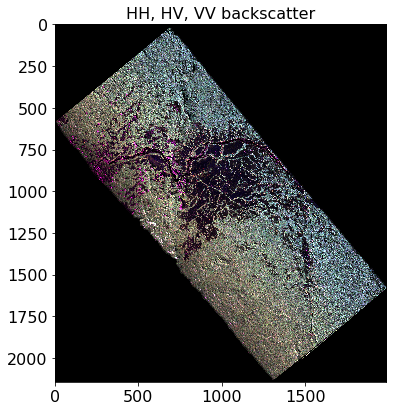

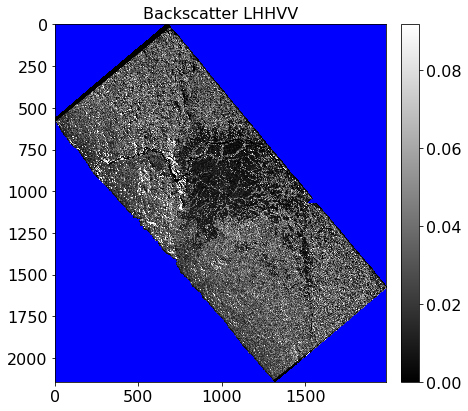

In [30]:
# Show the geographic extent and other relevant info, like the number of bands
# Display the bands associated with filenames 1-1 (LHH), 2-2 (LHV) and the 4-4 (LVV) in a Pauli composite

plant.ls(cov_LHH)

# crop/multi-look radar files
filter_options = dict(options)
filter_options['nlooks'] = [nlooks_az, nlooks_rg]
_ = plant.filter(cov_LHH, output_file=file_LHH, **filter_options)
_ = plant.filter(cov_LHV, output_file=file_LHV, **filter_options)
_ = plant.filter(cov_LVV, output_file=file_LVV, **filter_options)
_ = plant.filter(cov_LHHVV, output_file=file_LHHVV, **filter_options)

# Apply same incidence angle correction as ESA and normaalize to number of looks (9*41=369)
plant.geocode(inc_file_sr, bbox_file=cov_LHH, output_file=inc_file, topo_dir=topo_dir, **options)
plant.filter(inc_file, output_file=sin_inc_file, deg2rad=True, sin=True, **filter_options)
_ = plant.util(file_LHH, sin_inc_file, 1.0/369, output_file=file_LHH, mult=True, **options)
_ = plant.util(file_LHV, sin_inc_file, 1.0/369, output_file=file_LHV, mult=True, **options)
_ = plant.util(file_LVV, sin_inc_file, 1.0/369, output_file=file_LVV, mult=True, **options)
_ = plant.util(file_LHHVV, sin_inc_file, 1.0/369, output_file=file_LHHVV, mult=True, **options)
              

# display Lex
_ = plant.display(file_LHH, file_LHV, file_LVV, title='HH, HV, VV backscatter', **display_options)
_ = plant.display(file_LHHVV, title='Backscatter LHHVV', **display_options)

## 4. Display ESA radar data over Lope National Park

Use `plant.display()` to read the geocoded and radiometric terrain corrected ESA data. Fast-browse could also be used if cloud-optimized GeoTIFF are available or generated for the dataset. 

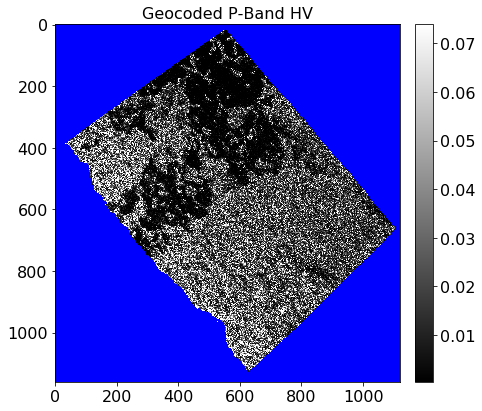

In [31]:
_ = plant.display(file_PHV, 
                  title='Geocoded P-Band HV', 
                  percent=90, 
                  **display_options)

## 5. Read ESA-provided local field data for Lope National Park 

Field data consists in a list of trees with height and/or diameter at breast height measurements. Measured trees are organized in 13 1ha or 0.5ha polygons or "plots", for which mean canopy height and above-ground biomass is calculated using the Chave et Al. (2005)'s approach. The final objective is to have an estimate of the biomass within each plot in order to calibrate backscatter-biomass models.

In [32]:
# Field data
tdt_dir = './input/agb/lope_tdt' #_csv
tdt_files = path.join(tdt_dir, 'LNL_??_PlotDump.txt')
tdt_ref = path.join(tdt_dir, 'Plot_coord_AfriSAR_NL_np.txt')
e_file = path.join(tdt_dir, 'E.tif')
numberFieldPlots = 13

field_options = dict(options)
# field_options.update(options)
field_options['ref'] = tdt_ref
field_options['first_line'] = 2
field_options['separator'] = 'TAB'#','
# field_options['lvis'] = lvis_l2_files
field_options['save_as_raster_gdal'] = True
field_options['step'] = 0.000001
field_options['chave2014_E'] = e_file
# field_options['output_skip_if_existent'] = True
field_options['force'] = True

plot_ha_file = path.join(output_field, 'plot_??/plot_??_agb_plot_ha.bin')
for i in range(1, numberFieldPlots):
    print(f'processing field plot {i}...')
    plot_number=f'{i:02}'
    input_file = path.join(tdt_dir, f'LNL_{plot_number}_PlotDump.txt')
    output_file = path.join(output_field, f'plot_{plot_number}/plot_{plot_number}')
    plant.agb_samples(input_file, output_file=output_file, **field_options)

processing field plot 1...
processing field plot 2...
processing field plot 3...
processing field plot 4...
processing field plot 5...
processing field plot 6...
processing field plot 7...
processing field plot 8...
processing field plot 9...
processing field plot 10...
processing field plot 11...
processing field plot 12...


## 6. Display field data

Pick one of the plots and display the height of each tree within the plot. Biomass could also be displayed by changing the name of the file being displayed. 

PLAnT 0.0.37dev - plant_display.py "./input/afrisar_maap/output-D2-demo/output_field/plot_10/plot_10_tree_height_field_estimated.bin" --title "Field-estimated tree height [meters]" --no-bash
input 1: ./input/afrisar_maap/output-D2-demo/output_field/plot_10/plot_10_tree_height_field_estimated.bin (band: 0)
    arguments: ./input/afrisar_maap/output-D2-demo/output_field/plot_10/plot_10_tree_height_field_estimated.bin --title Field-estimated tree height [meters] --no-bash
    format: GTiff
    dtype: float32
    geotransform: [11.608066780113257, 1.000226510067669e-06, 0, -0.2216010599635701, 0, 1.0000728597449414e-06, 11.609258049886746, -0.2205039800364299, 1192, 1098]
opening: ./input/afrisar_maap/output-D2-demo/output_field/plot_10/plot_10_tree_height_field_estimated.bin (GDAL: GTiff) 
    width: 1192 
    length: 1098 
    min (color scale) = 4.0
    max (color scale) = 39.362967720031776
image options:
    background color: BLUE
    facecolor: WHITE


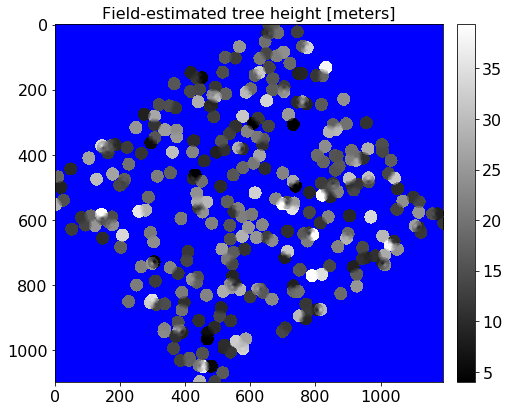

In [42]:
_ = plant.display(path.join(output_field, 'plot_10', 'plot_10_tree_height_field_estimated.bin'),
                  title="Field-estimated tree height [meters]")

## 7. Co-locate field with NASA and ESA radar data

Resample ESA and NASA data onto field data and average backscatter within each field plot for a given polarization and radar frequency. Each polarization and frequency is processed by a separate line in the code block below. Resampling can be achieved in several ways.

In [35]:
agb_vect = plant.plant_info(plot_ha_file, input_sort=True, mean=True, **options)
# plant.display('0:12', agb_vect, first_image_as_y=True, title='Field Data', label_x='plot number', label_y='AGB [Mg/ha]')
# plant.display(agb_vect, first_image_as_x=True, title='Field Data AGB histogram',  nbins=20, hist=True, label_x='AGB [Mg/ha]', **display_options)
# plant.display(agb_vect, title='Field Data AGB', labely='Plot number', decimal_places=2, **display_options)
mean_LHH_vect = np.zeros((12))
mean_LHV_vect = np.zeros((12))
mean_LVV_vect = np.zeros((12))
mean_LHHVV_vect = np.zeros((12))
mean_PHV_vect = np.zeros((12))
# lvis_tree_height = np.zeros((12))

# options = {'force': True}
for i in range(12):
    print(f'processing field plot {i}...')
    plot_number=f'{(i+1):02}'
    est_tree_height_file = path.join(output_field, f'plot_{plot_number}/plot_{plot_number}_tree_height_field_estimated.bin')
    est_tree_height_radar_file_LHH = path.join(output_field, f'plot_{plot_number}/plot_{plot_number}_tree_height_field_radar_LHH.bin')
    est_tree_height_radar_file_LHV = path.join(output_field, f'plot_{plot_number}/plot_{plot_number}_tree_height_field_radar_LHV.bin')
    est_tree_height_radar_file_LVV = path.join(output_field, f'plot_{plot_number}/plot_{plot_number}_tree_height_field_radar_LVV.bin')
    est_tree_height_radar_file_LHHVV = path.join(output_field, f'plot_{plot_number}/plot_{plot_number}_tree_height_field_radar_LHHVV.bin')
    est_tree_height_radar_file_PHV = path.join(output_field, f'plot_{plot_number}/plot_{plot_number}_tree_height_field_radar_PHV.bin')

    _ = plant.mosaic(file_LHH, bbox_file=est_tree_height_file, output_file=est_tree_height_radar_file_LHH, interp='average', **options)
    _ = plant.mosaic(file_LHV, bbox_file=est_tree_height_file, output_file=est_tree_height_radar_file_LHV, interp='average', **options)
    _ = plant.mosaic(file_LVV, bbox_file=est_tree_height_file, output_file=est_tree_height_radar_file_LVV, interp='average', **options)
    _ = plant.mosaic(file_LHHVV, bbox_file=est_tree_height_file, output_file=est_tree_height_radar_file_LHHVV, interp='average', **options)
    _ = plant.mosaic(file_PHV, bbox_file=est_tree_height_file, output_file=est_tree_height_radar_file_PHV, interp='average', **options)
    
    _ = plant.util(est_tree_height_radar_file_LHH, output_file=est_tree_height_radar_file_LHH, mask_less=0, mask_ref=est_tree_height_file, **options) 
    _ = plant.util(est_tree_height_radar_file_LHV, output_file=est_tree_height_radar_file_LHV, mask_less=0, mask_ref=est_tree_height_file, **options) 
    _ = plant.util(est_tree_height_radar_file_LVV, output_file=est_tree_height_radar_file_LVV, mask_less=0, mask_ref=est_tree_height_file, **options) 
    _ = plant.util(est_tree_height_radar_file_LHHVV, output_file=est_tree_height_radar_file_LHHVV, mask_less=0, mask_ref=est_tree_height_file, **options) 
    _ = plant.util(est_tree_height_radar_file_PHV, output_file=est_tree_height_radar_file_PHV, mask_less=0, mask_ref=est_tree_height_file, **options) 

    mean_LHH_vect[i] = plant.plant_info(est_tree_height_radar_file_LHH, data_mean=True, **options).image[0][0]
    mean_LHV_vect[i] = plant.plant_info(est_tree_height_radar_file_LHV, data_mean=True, **options).image[0][0]
    mean_LVV_vect[i] = plant.plant_info(est_tree_height_radar_file_LVV, data_mean=True, **options).image[0][0]
    mean_LHHVV_vect[i] = plant.plant_info(est_tree_height_radar_file_LHHVV, data_mean=True, **options).image[0][0]
    mean_PHV_vect[i] = plant.plant_info(est_tree_height_radar_file_PHV, data_mean=True, **options).image[0][0]
    print('    backscatter mean (LHH, LHV, LVV, LHHVV, PHV):', mean_LHH_vect[i], mean_LHV_vect[i], mean_LVV_vect[i], mean_LHHVV_vect[i], mean_PHV_vect[i])

# mean_LHH_db_vect = plant.get_db(mean_LHH_vect)
# mean_LHV_db_vect = plant.get_db(mean_LHV_vect)
print('mean_LHH_vect', plant.get_db(mean_LHH_vect))
print('mean_LHV_vect', mean_LHV_vect)
print('mean_LVV_vect', mean_LVV_vect)
print('mean_LHHVV_vect', mean_LHHVV_vect)
print('mean_PHV_vect', mean_PHV_vect)
# print('*** mean_LHH_db_vect', mean_LHH_db_vect)
# print('*** mean_LHV_db_vect', mean_LHV_db_vect)
print('agb_vect', agb_vect)

LHH_vect_file = path.join(output_field, 'LHH_vect.bin')
LHV_vect_file = path.join(output_field, 'LHV_vect.bin')
LVV_vect_file = path.join(output_field, 'LVV_vect.bin')
LHHVV_vect_file = path.join(output_field, 'LHHVV_vect.bin')
PHV_vect_file = path.join(output_field, 'PHV_vect.bin')
agb_vect_file = path.join(output_field, 'agb_vect.bin')
_ = plant.util(mean_LHH_vect, output_file=LHH_vect_file, **options)
_ = plant.util(mean_LHV_vect, output_file=LHV_vect_file, **options)
_ = plant.util(mean_LVV_vect, output_file=LVV_vect_file, **options)
_ = plant.util(mean_LHHVV_vect, output_file=LHHVV_vect_file, **options)
_ = plant.util(mean_PHV_vect, output_file=PHV_vect_file, **options)
# _ = plant.util(mean_LHH_db_vect, output_file=path.join(output_field, 'LHH_db_vect.bin'), force=True)
# _ = plant.util(mean_LHV_db_vect, output_file=path.join(output_field, 'LHV_db_vect.bin'), force=True)
_ = plant.util(agb_vect, output_file=agb_vect_file, **options)


processing field plot 0...
    backscatter mean (LHH, LHV, LVV, LHHVV, PHV): 0.019 0.002 0.021 0.013 0.004
processing field plot 1...
    backscatter mean (LHH, LHV, LVV, LHHVV, PHV): 0.026 0.003 0.026 0.016 0.004
processing field plot 2...
    backscatter mean (LHH, LHV, LVV, LHHVV, PHV): 0.046 0.007 0.032 0.018 0.009
processing field plot 3...
    backscatter mean (LHH, LHV, LVV, LHHVV, PHV): 0.078 0.024 0.068 0.021 0.041
processing field plot 4...
    backscatter mean (LHH, LHV, LVV, LHHVV, PHV): 0.083 0.022 0.058 0.015 0.03
processing field plot 5...
    backscatter mean (LHH, LHV, LVV, LHHVV, PHV): 0.108 0.033 0.1 0.021 0.026
processing field plot 6...
    backscatter mean (LHH, LHV, LVV, LHHVV, PHV): 0.093 0.031 0.082 0.019 0.062
processing field plot 7...
    backscatter mean (LHH, LHV, LVV, LHHVV, PHV): 0.091 0.026 0.071 0.014 0.043
processing field plot 8...
    backscatter mean (LHH, LHV, LVV, LHHVV, PHV): 0.102 0.03 0.087 0.027 0.055
processing field plot 9...
    backscatte

## 8. Fit models of NASA HV backscatter vs field biomass 

After co-location of HV sigma-0 backscatter with field data, we fit a three-parameter model (_Water Cloud Model_) of the above-ground biomass vs radar backscatter using field-estimated biomass. Model appears to fit well to data even with the non-optimized processing that started from Geocoded L2 Covariance Matrix. 

PLAnT 0.0.37dev (API) - plant_display.py "./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin" "./input/afrisar_maap/output-D2-demo/output_field/LHV_vect.bin" --db --name "HV" --function-fit "wcm_db" --out-function-fit "coeffs_wcm.bin" --title "" --first-image-as-x --label-y "Backscatter" --label-x "AGB [Mg/ha]" --force --marker-size "300" --scatterplot --mute
input 1: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin (band: 0)
    arguments: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin
    format: ENVI
    dtype: float64
opening: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin (GDAL: ENVI) 
    width: 12 
    length: 1 
    nbins = 10
    min = 0.149
    max = 355.872


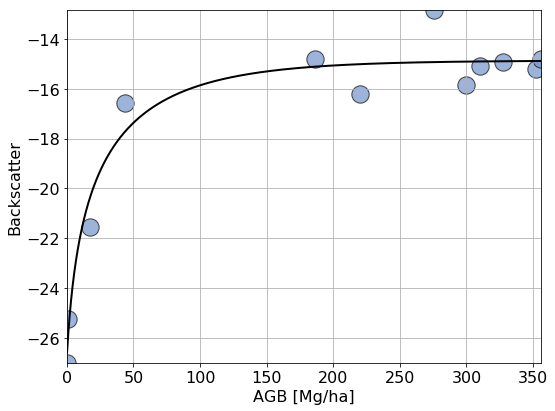

In [37]:
display_options_fit_str = (' --title "" --first-image-as-x --label-y "Backscatter" --label-x "AGB [Mg/ha]" --force --marker-size 300 --scatterplot --mute')
_ = plant.execute(f'plant_display.py {agb_vect_file}  {LHV_vect_file} --db --name "HV" --function-fit wcm_db --out-function-fit coeffs_wcm.bin {display_options_fit_str}')


## 9. Compare polarizations vs field biomass

Several combinations of polarimetric channels, including the HHVV correlation, are examined in terms of model fit. Polarimetric intensities HH, HV and VV show similar performance, as opposed to HHVV that has very little correlation between field-derived biomass and backscatter as expected.

PLAnT 0.0.37dev (API) - plant_display.py "./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin" "./input/afrisar_maap/output-D2-demo/output_field/LHH_vect.bin" --db --name "HH" "./input/afrisar_maap/output-D2-demo/output_field/LHV_vect.bin" --db --name "HV" "./input/afrisar_maap/output-D2-demo/output_field/LVV_vect.bin" --db --name "VV" --function-fit "wcm_db" --out-function-fit "coeffs_wcm.bin" --title "" --first-image-as-x --label-y "Backscatter" --label-x "AGB [Mg/ha]" --force --marker-size "300" --scatterplot --mute
input 1: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin (band: 0)
    arguments: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin
    format: ENVI
    dtype: float64
opening: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin (GDAL: ENVI) 
    width: 12 
    length: 1 
    nbins = 10
    min = 0.149
    max = 355.872
input 2: ./input/afrisar_maap/output-D2-demo/output_field/LHH_vect.bin (band: 0)
    arguments: ./input/afr

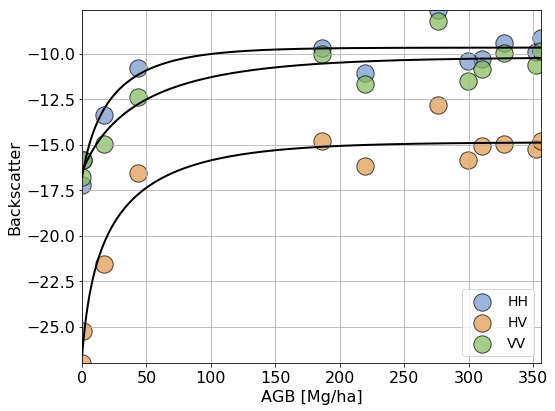

In [38]:
_ = plant.execute(f'plant_display.py {agb_vect_file} {LHH_vect_file} --db --name "HH" {LHV_vect_file} --db --name "HV" {LVV_vect_file} --db --name "VV" --function-fit wcm_db --out-function-fit coeffs_wcm.bin {display_options_fit_str}')

PLAnT 0.0.37dev (API) - plant_display.py "./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin" "./input/afrisar_maap/output-D2-demo/output_field/LHHVV_vect.bin" --db --name "HHVV" --function-fit "wcm_db" --out-function-fit "coeffs_wcm.bin" --title "" --first-image-as-x --label-y "Backscatter" --label-x "AGB [Mg/ha]" --force --marker-size "300" --scatterplot --mute
input 1: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin (band: 0)
    arguments: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin
    format: ENVI
    dtype: float64
opening: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin (GDAL: ENVI) 
    width: 12 
    length: 1 
    nbins = 10
    min = 0.149
    max = 355.872


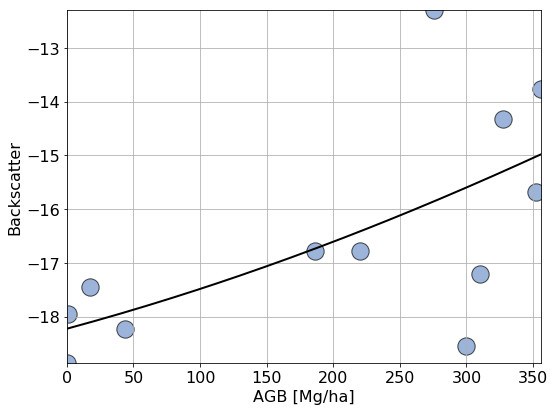

In [39]:
_ = plant.execute(f'plant_display.py {agb_vect_file} {LHHVV_vect_file} --db --name "HHVV" --function-fit wcm_db --out-function-fit coeffs_wcm.bin {display_options_fit_str}')

## 10. Compare NASA L- and ESA P-band data in preparation for NISAR and BIOMASS missions

Fit the Water-Cloude Model to both L-band (NASA/UAVSAR) and P-band (ESA/F-SAR) data using field data. Only 2-3 dB difference are observed between L-band and P-band - more investigation will follow.

PLAnT 0.0.37dev (API) - plant_display.py "./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin" "./input/afrisar_maap/output-D2-demo/output_field/LHV_vect.bin" --db --name "NASA L-HV" "./input/afrisar_maap/output-D2-demo/output_field/PHV_vect.bin" --db --name "ESA P-HV" --function-fit "wcm_db" --out-function-fit "coeffs_wcm.bin" --first-image-as-x --label-y "Backscatter" --label-x "AGB [Mg/ha]" --force --marker-size "300" --scatterplot --mute
input 1: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin (band: 0)
    arguments: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin
    format: ENVI
    dtype: float64
opening: ./input/afrisar_maap/output-D2-demo/output_field/agb_vect.bin (GDAL: ENVI) 
    width: 12 
    length: 1 
    nbins = 10
    min = 0.149
    max = 355.872
input 2: ./input/afrisar_maap/output-D2-demo/output_field/LHV_vect.bin (band: 0)
    arguments: ./input/afrisar_maap/output-D2-demo/output_field/LHV_vect.bin --db --name NASA L-HV
    na

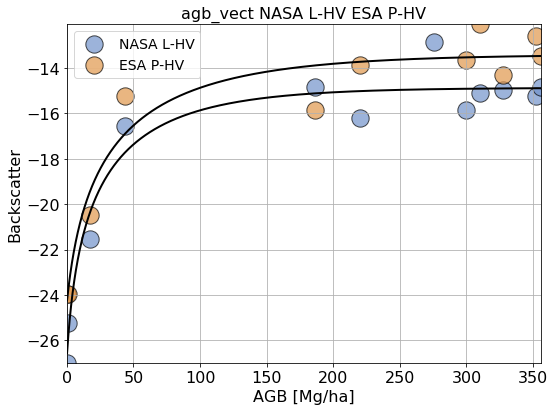

In [40]:
display_options_fit_str = (' --first-image-as-x --label-y "Backscatter" --label-x "AGB [Mg/ha]" --force --marker-size 300 --scatterplot --mute')
_ = plant.execute(f'plant_display.py {agb_vect_file} {LHV_vect_file} --db --name "NASA L-HV" {PHV_vect_file} --db --name "ESA P-HV" --function-fit wcm_db --out-function-fit coeffs_wcm.bin {display_options_fit_str}')
# _ = plant.execute(f'plant_display.py {agb_vect_file}  {PHV_vect_file} --name "P-HV" --function-fit wcm --out-function-fit coeffs_wcm.bin {display_options_fit_str}')
